# 1. Library import

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import time
import numpy as np
import gc
import sys
import pickle
import copy
import pandas as pd
from AttentiveLayers import *
from Featurizer import *
from getFeatures import *

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from rdkit import Chem
from rdkit.Chem import QED
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns
sns.set(color_codes = True)

In [2]:
import os
os.getcwd()

'/home/dohyeon/hERGAT'

In [3]:
import os
os.chdir('/home/dohyeon/hERGAT/dataset')

# dataset 불러오기 

## Canonical smiles를 기준으로 중복 데이터 삭제

In [4]:
task_name = 'Class'
tasks = ['Class']
raw_filename = "hERG dataset.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.SMILES.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["SMILES"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)
smiles_tasks_df.head()

number of all smiles:  7933
number of successfully processed smiles:  7933


,Unnamed: 0,SMILES,pIC50,hERG,Class,cano_smiles
0,0,Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@@H](C3)Oc4cccc(c4...,9.85,0.979,1,Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@H](Oc2cccc(C(N)=O...
1,1,COc1nc2ccc(Br)cc2cc1[C@@H](c3ccccc3)[C@@](O)(C...,9.70,0.994,1,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...
2,2,NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCCc...,9.60,0.986,1,NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCCc...
3,3,Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@@H](C3)Oc4cccc(c4...,9.59,0.949,1,Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@H](Oc2cccc(C(N)=O...
4,4,NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCc4...,9.42,0.983,1,NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCc2...


In [5]:
random_seed =100
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()
radius = 3
T = 2
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num # 2 

In [6]:
len(smiles_tasks_df)

7933

In [7]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]

uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

# cano_smiles안에 uncovered값과 겹치는 경우에 삭제
smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

feature_dicts = get_smiles_dicts(smilesList)
# keys = smiles값들이 cano_smiles값안에 있으면 두고 없다면 삭제
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())] 
uncovered_df = smiles_tasks_df.drop(remained_df.index) 
uncovered_df # 최종적으로 uncovered_df에는 get_smiles_dicts로 바꾼 값과 cano_smiles와 비교하였을 때 삭제

Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3ccc(S(F)(F)(F)(F)F)cc3)C2)n1C
Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3cccc(S(F)(F)(F)(F)F)c3)C2)n1C
[Cl-]


,Unnamed: 0,SMILES,pIC50,hERG,Class,cano_smiles
1240,1240,Cc1ncoc1c2nnc(SCCCN3CC4CC4(C3)c5ccc(cc5)S(F)(F...,6.1,0.954,1,Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3ccc(S(F)(F)(F)(F...
1671,1671,Cc1ncoc1c2nnc(SCCCN3CC4CC4(C3)c5cccc(c5)S(F)(F...,5.9,0.950,1,Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3cccc(S(F)(F)(F)(...
3704,3704,[Cl-],5.2,0.972,1,[Cl-]


In [8]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["SMILES",task]] # 
    positive_df = remained_df[remained_df[task] == 1][["SMILES",task]] # 
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])
# weights = [[2.862815884476534, 1.5368217054263567]]


# train/test/valid split
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [9]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(6344, 6)
(793, 6)
(793, 6)


In [10]:
print('train_df label의 shape')
print(train_df['Class'].value_counts())
print('test_df label의 shape')
print(test_df['Class'].value_counts())
print('valid_df label의 shape')
print(valid_df['Class'].value_counts())

train_df label의 shape
1    4102
0    2242
Name: Class, dtype: int64
test_df label의 shape
1    537
0    256
Name: Class, dtype: int64
valid_df label의 shape
1    521
0    272
Name: Class, dtype: int64


여기에서 test_df를 사용할 예정

In [11]:
best_param = {"roc_epoch": 0, "valid_roc": 0, "loss_epoch": 0, "valid_loss": float('inf')}
best_param


{'roc_epoch': 0, 'valid_roc': 0, 'loss_epoch': 0, 'valid_loss': inf}

In [12]:
# bayesian optimizer로 찾은 최적의 parameter 값 #

batch_size = 256
p_dropout = 0.4
fingerprint_dim = 200
learning_rate = 3.3
weight_decay = 4.8
radius = 3
T = 2

## Feature vis를 위해 데이터 학습

In [13]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]], feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = [nn.CrossEntropyLoss(weight=torch.Tensor(weight), reduction='mean') for weight in weights]

# loss_function = [nn.BCEWithLogitsLoss(pos_weight = pos_weight, weight=torch.Tensor(weight), reduction='mean') for weight in weights]

In [14]:
model = Fingerprint_viz(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)

optimizer = optim.Adam(model.parameters(), lr = 10**-learning_rate, weight_decay = 10**-weight_decay)

model_parameters = filter(lambda p : p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

1145606


In [15]:
for key, value in feature_dicts.items():
    print(key)

smiles_to_atom_mask
smiles_to_atom_info
smiles_to_bond_info
smiles_to_atom_neighbors
smiles_to_bond_neighbors
smiles_to_rdkit_list


In [16]:
for name, param in model.named_parameters():
    print(name, param.data.shape)

atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200])
attend

In [17]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(30)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)    
        
        #selected_rows = batch_df[batch_df['cano_smiles'] == smiles_list].drop(columns=['SMILES', 'Class', 'cano_smiles'])
        #physicochemical_features= torch.tensor(selected_rows.to_numpy(dtype=np.float32), dtype=torch.float)

        atoms_prediction, atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, mol_attention_weight_viz, mol_prediction = model(torch.Tensor(x_atom).cpu(),torch.Tensor(x_bonds).cpu(),torch.LongTensor(x_atom_index).cpu(),torch.LongTensor(x_bond_index).cpu(),torch.Tensor(x_mask).cpu())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()
        
        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []

    
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        #selected_rows = batch_df[batch_df['cano_smiles'] == smiles_list].drop(columns=['SMILES', 'Class', 'cano_smiles'])
       # physicochemical_features= torch.tensor(selected_rows.to_numpy(dtype=np.float32), dtype=torch.float)3
#        physicochemical_features = physicochemical_features.expand(batch_size, -1)
        
        atoms_prediction, atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, mol_attention_weight_viz, mol_prediction = model(torch.Tensor(x_atom).cpu(),torch.Tensor(x_bonds).cpu(),torch.LongTensor(x_atom_index).cpu(),torch.LongTensor(x_bond_index).cpu(),torch.Tensor(x_mask).cpu())

        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]

            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss = loss_function[i](
                y_pred_adjust,
                torch.LongTensor(y_val_adjust))
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.numpy()[:,1]
            losses_list.append(loss.detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    # 시행할때마다 모델에서 최적의 optimal_threshold값을 찾아 성능평가
    
    def find_optimal_threshold(precision, recall, thresholds):
        f1_scores = 2*((precision*recall)/(precision+recall))
        index = np.argmax(f1_scores)
        return thresholds[index]

    test_prc = []
    test_thresholds = []
    optimal_thresholds = []
    for i in range(len(tasks)):
        precision, recall, thresholds = precision_recall_curve(y_val_list[i], y_pred_list[i])
        optimal_threshold = find_optimal_threshold(precision, recall, thresholds)
        optimal_thresholds.append(optimal_threshold)
        test_prc.append(auc(recall, precision))
        test_thresholds.append(thresholds)
        
        
    test_precision = [precision_score(y_val_list[i], (np.array(y_pred_list[i]) > optimal_thresholds[i]).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],(np.array(y_pred_list[i]) >optimal_thresholds[i]).astype(int)) for i in range(len(tasks))]
    test_f1_score = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(test_precision, test_recall)]    
    conf_matrices = [confusion_matrix(y_val_list[i], (np.array(y_pred_list[i]) > optimal_thresholds[i]).astype(int)) for i in range(len(tasks))]
    test_sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in conf_matrices]
    test_specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in conf_matrices]
    test_acc = [accuracy_score(y_val_list[i], (np.array(y_pred_list[i]) > optimal_thresholds[i]).astype(int)) for i in range(len(tasks))]
    fpr_list, tpr_list, thresholds2 = [], [], []
    for i in range(len(tasks)):
        fpr, tpr, thresholds = roc_curve(y_val_list[i], y_pred_list[i])
        fpr_list.append(fpr)
        tpr_list.append(tpr)
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_acc, test_roc, test_prc, test_precision, test_recall, test_f1_score, test_loss, test_sensitivity, test_specificity, fpr_list, tpr_list, optimal_thresholds

In [18]:
best_param = {"roc_epoch": 0, "valid_roc": 0, "loss_epoch": 0, "valid_loss": float('inf')}
best_param

{'roc_epoch': 0, 'valid_roc': 0, 'loss_epoch': 0, 'valid_loss': inf}

In [19]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf
        self.counter = 0
        self.patience = patience
        self.early_stop = False

    def step(self, loss):
        if loss < self.loss:
            self.loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def should_step(self):
        return self.early_stop
    
early_stopping = EarlyStopping(patience = 15)    

In [20]:
import os
os.chdir('/home/dohyeon/hERGAT')

epochs = 1000
train_loss_vis2 = []
valid_loss_vis2 = []
train_roc2 = []
valid_roc2 = []
train_sensitivity2 = []
train_specificity2 = []
valid_precision2 = []
valid_recall2 = []
valid_optimal_thresholds2=[]

for epoch in range(epochs):    
    start_time = time.time() # epoch의 시작시간
    
    train(model, train_df, optimizer, loss_function)
  
    
    train_acc, train_roc, train_prc, train_precision, train_recall, train_f1_score, train_loss, train_sensitivity, train_specificity, train_fpr, train_tpr, train_optimal_thresholds= eval(model, train_df)
    valid_acc, valid_roc, valid_prc, valid_precision, valid_recall, valid_f1_score, valid_loss, valid_sensitivity, valid_specificity, valid_fpr, valid_tpr, valid_optimal_thresholds= eval(model, valid_df)
    train_roc_mean = np.array(train_roc2).mean()
    valid_roc_mean = np.array(valid_roc2).mean()
    train_loss_vis2.append(train_loss)
    valid_loss_vis2.append(valid_loss)
    train_roc2.append(train_roc)
    valid_roc2.append(valid_roc)
    train_sensitivity2.append(train_sensitivity)
    train_specificity2.append(train_specificity)
    valid_precision2.append(valid_precision)
    valid_recall2.append(valid_recall)
    valid_optimal_thresholds2.append(valid_optimal_thresholds)
    
    
    

        
    if valid_roc_mean > 0.60:
             torch.save(model, 'saved_model_viz/model_'+prefix_filename+'_'+str(epoch)+'.pt')                
            
    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
                
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_acc"+":"+str(train_acc)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_precision"+":"+str(train_precision)+'\n'
        +"train_recall"+":"+str(train_recall)+'\n'
        +"train_specificity"+":"+str(train_specificity)+'\n'\
        +"train_f1_score"+":"+str(train_f1_score)+'\n'
        +"train_loss"+":"+str(train_loss)+'\n'\
        +"valid_loss"+":"+str(valid_loss)+'\n'
        )
    
#     if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
#         break
    early_stopping.step(valid_loss)
    if early_stopping.should_step():
        print('early stopping')
        
        break
    
    
    end_time = time.time() # 각 epoch의 종료시간
    elapsed_time = end_time - start_time # 경과시간
    print(f'Epoch {epoch+1} finished in {elapsed_time:.2f} seconds.')
    

/tmp/ipykernel_818347/2512374299.py:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*((precision*recall)/(precision+recall))
/home/iis-lab/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_818347/2512374299.py:118: RuntimeWarning: invalid value encountered in double_scalars
  test_f1_score = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(test_precision, test_recall)]
/tmp/ipykernel_818347/3291721738.py:23: RuntimeWarning: Mean of empty slice.
  train_roc_mean = np.array(train_roc2).mean()
/home/iis-lab/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_81834

EPOCH:	0
train_acc:[0.35340479192938207]
train_roc:[0.6276119196875742]
valid_roc:[0.6259738060291294]
train_precision:[0.0]
train_recall:[0.0]
train_specificity:[1.0]
train_f1_score:[nan]
train_loss:0.6964716
valid_loss:0.69099313

Epoch 1 finished in 55.99 seconds.


/tmp/ipykernel_818347/2512374299.py:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*((precision*recall)/(precision+recall))
/home/iis-lab/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_818347/2512374299.py:118: RuntimeWarning: invalid value encountered in double_scalars
  test_f1_score = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(test_precision, test_recall)]


EPOCH:	1
train_acc:[0.35340479192938207]
train_roc:[0.6376903349076689]
valid_roc:[0.6349779835158631]
train_precision:[0.0]
train_recall:[0.0]
train_specificity:[1.0]
train_f1_score:[nan]
train_loss:0.6908924
valid_loss:0.68571186

Epoch 2 finished in 46.96 seconds.


/tmp/ipykernel_818347/2512374299.py:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*((precision*recall)/(precision+recall))
/home/iis-lab/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_818347/2512374299.py:118: RuntimeWarning: invalid value encountered in double_scalars
  test_f1_score = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(test_precision, test_recall)]


EPOCH:	2
train_acc:[0.35340479192938207]
train_roc:[0.6501610254304703]
valid_roc:[0.6410677994806369]
train_precision:[0.0]
train_recall:[0.0]
train_specificity:[1.0]
train_f1_score:[nan]
train_loss:0.62982374
valid_loss:0.67358595

Epoch 3 finished in 43.68 seconds.
EPOCH:	3
train_acc:[0.6640920554854981]
train_roc:[0.6905773320035786]
valid_roc:[0.6805422264875239]
train_precision:[0.6606356968215159]
train_recall:[0.9880546075085325]
train_specificity:[0.07136485280999108]
train_f1_score:[0.7918335449838819]
train_loss:0.6116414
valid_loss:0.6535354

Epoch 4 finished in 46.07 seconds.
EPOCH:	4
train_acc:[0.6626733921815889]
train_roc:[0.7107566161890525]
valid_roc:[0.704344021677769]
train_precision:[0.6604514229636899]
train_recall:[0.984397854705022]
train_specificity:[0.07404103479036575]
train_f1_score:[0.7905246671887236]
train_loss:0.61473346
valid_loss:0.6204887

Epoch 5 finished in 47.31 seconds.
EPOCH:	5
train_acc:[0.6629886506935687]
train_roc:[0.7193840192834722]
valid_r

/tmp/ipykernel_818347/2512374299.py:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*((precision*recall)/(precision+recall))
/home/iis-lab/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_818347/2512374299.py:118: RuntimeWarning: invalid value encountered in double_scalars
  test_f1_score = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(test_precision, test_recall)]


EPOCH:	35
train_acc:[0.7671815889029003]
train_roc:[0.8314288062958344]
valid_roc:[0.8123588686914305]
train_precision:[0.7747540297257693]
train_recall:[0.9022428083861531]
train_specificity:[0.52007136485281]
train_f1_score:[0.8336524383376507]
train_loss:0.53030646
valid_loss:0.5460272

Epoch 36 finished in 46.48 seconds.
EPOCH:	36
train_acc:[0.7733291298865069]
train_roc:[0.8388701840793921]
valid_roc:[0.8152097211245344]
train_precision:[0.7801851072780817]
train_recall:[0.9041930765480254]
train_specificity:[0.5338983050847458]
train_f1_score:[0.8376242095754292]
train_loss:0.49235666
valid_loss:0.53196836

Epoch 37 finished in 47.63 seconds.
EPOCH:	37
train_acc:[0.7779003783102144]
train_roc:[0.841246475360032]
valid_roc:[0.8119143050694366]
train_precision:[0.7838920514442336]
train_recall:[0.9063871282301317]
train_specificity:[0.5428189116859946]
train_f1_score:[0.8407009609949123]
train_loss:0.49665764
valid_loss:0.5349827

Epoch 38 finished in 45.58 seconds.
EPOCH:	38
train

/tmp/ipykernel_818347/2512374299.py:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*((precision*recall)/(precision+recall))
/home/iis-lab/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_818347/2512374299.py:118: RuntimeWarning: invalid value encountered in double_scalars
  test_f1_score = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(test_precision, test_recall)]


EPOCH:	57
train_acc:[0.8121059268600253]
train_roc:[0.8868034935200556]
valid_roc:[0.8341989386925597]
train_precision:[0.8089171974522293]
train_recall:[0.9288152120916626]
train_specificity:[0.5985727029438002]
train_f1_score:[0.8647299137539719]
train_loss:0.42367598
valid_loss:0.5257162

Epoch 58 finished in 48.81 seconds.
EPOCH:	58
train_acc:[0.8240857503152585]
train_roc:[0.89290743272249]
valid_roc:[0.838383481991645]
train_precision:[0.8373248983280615]
train_recall:[0.9034617259873232]
train_specificity:[0.6788581623550402]
train_f1_score:[0.8691369606003753]
train_loss:0.41907674
valid_loss:0.5032126

Epoch 59 finished in 49.68 seconds.
EPOCH:	59
train_acc:[0.8204602774274905]
train_roc:[0.8944168354593894]
valid_roc:[0.8378119001919385]
train_precision:[0.8166274845052361]
train_recall:[0.931496830814237]
train_specificity:[0.6173059768064229]
train_f1_score:[0.8702881220817675]
train_loss:0.414525
valid_loss:0.51251304

Epoch 60 finished in 52.14 seconds.
EPOCH:	60
train_ac

In [29]:
best_param['roc_epoch']

70

## Feature visualization

In [21]:
import os
os.getcwd()

'/home/dohyeon/hERGAT'

In [31]:
best_model = torch.load('saved_model_viz/model_hERG dataset'+'_'+str(best_param['roc_epoch'])+'.pt')     # best_param['roc_epoch']

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

In [32]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]], feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

In [33]:
# 기존에 best_model_wts에 저장되어있는 가중치값들을 여기에 적용시킨다
model_for_viz = Fingerprint_viz(radius, T, num_atom_features, num_bond_features,fingerprint_dim, output_units_num, p_dropout)
model_for_viz.load_state_dict(best_model_wts)

<All keys matched successfully>

In [34]:
# 두 모델의 특정 layer에서 가중치가 동일한지 확인하는 코드
# 같다면 1을 출력
(best_model.align[0].weight == model_for_viz.align[0].weight).all()

tensor(True)

In [35]:
def eval_for_viz(model, viz_list):
    model.eval()
    test_acc_list = []
    test_roc_list = []
    mol_prediction_list = []
    atom_feature_list = []
    atom_weight_list = []
    mol_feature_list = []
    mol_feature_unbounded_list = []
    batch_list = []
    for i in range(0, len(viz_list), batch_size):
        batch = viz_list[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        
        #batch_df = viz_list.loc[train_batch,:]
        #smiles_list = batch_df.cano_smiles.values
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(viz_list,get_smiles_dicts(batch))
        
        atoms_prediction, atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, mol_attention_weight_viz, mol_prediction = model(
            torch.Tensor(x_atom).cpu(), torch.Tensor(x_bonds).cpu(),
            torch.LongTensor(x_atom_index).cpu(),
            torch.LongTensor(x_bond_index).cpu(),
            torch.Tensor(x_mask).cpu())

        mol_prediction_list.append(mol_prediction.cpu().detach().squeeze().numpy())
        atom_feature_list.append(np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)]))
        atom_weight_list.append(np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)]))
        mol_feature_list.append(np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)]))
        mol_feature_unbounded_list.append(np.stack([mol_feature_unbounded_viz[t].cpu().detach().numpy() for t in range(T)]))
        
    mol_prediction_array = np.concatenate(mol_prediction_list,axis=0)
    atom_feature_array = np.concatenate(atom_feature_list,axis=1)
    atom_weight_array = np.concatenate(atom_weight_list,axis=1)
    mol_feature_array = np.concatenate(mol_feature_list,axis=1)
    mol_feature_unbounded_array = np.concatenate(mol_feature_unbounded_list,axis=1)
#     print(mol_prediction_array.shape, atom_feature_array.shape, atom_weight_array.shape, mol_feature_array.shape)
    return mol_prediction_array, atom_feature_array, atom_weight_array, mol_feature_array, mol_feature_unbounded_array

In [36]:
viz_list = ['NCCc1ccc(S(=O)(=O)F)cc1']
    
# NCCc1ccc(S(=O)(=O)F)cc1    
#     'CCCCCCc1cccc(CCCCCC)[n+]1C',
# 'CCCCCCCN(CC)CCCCc1ccc(Cl)cc1',
# 'CCCCCC/C(C=O)=C\c1ccccc1',
# 'CCCCCCCN1CCC(Cc2ccccc2)CC1',
# 'CCCCCCCN(CC)CCCCCc1ccc(Cl)cc1',
# 'CCCCCCCN(CC)C/C=C/Cc1ccccc1'
    
mol_prediction_array, atom_feature_array, atom_weight_array, mol_feature_array, mol_feature_unbounded_array =  eval_for_viz(model_for_viz, viz_list)
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(viz_list,get_smiles_dicts(viz_list))

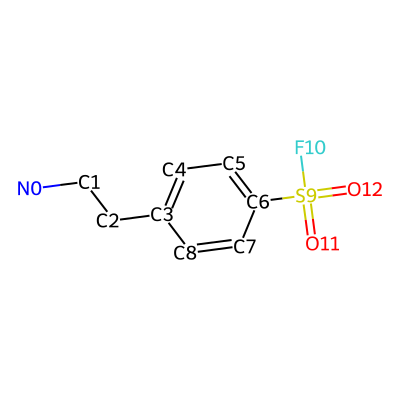

In [37]:
feature_sorted = []
weight_sorted = []
figures = []

for i, smiles in enumerate(viz_list):
#     draw molecules in svg format
    atom_mask = x_mask[i]
    index_atom = smiles_to_rdkit_list[smiles]
    atom_feature = atom_feature_array[:, i]
    atom_weight = atom_weight_array[:, i]
    mol_prediction = mol_prediction_array[i]
    mol_feature = mol_feature_array[:, i]
    feature_list = []
    weight_list = []
    feature_reorder = []
    weight_reorder = []
    for j, one_or_zero in enumerate(atom_mask):
        if one_or_zero == 1.0:
            feature_list.append(atom_feature[:,j])
            weight_list.append(atom_weight[:,j])
            
    feature_reorder = np.stack([feature_list[m] for m in np.argsort(index_atom)])
    weight_reorder = np.stack([weight_list[m] for m in np.argsort(index_atom)])
#     reorder for draw
    if i == 0:    
        draw_index = [0, 1, 2,3,4,5,6,9, 12 ,11, 10, 7, 8]
        feature_reorder = np.stack([feature_reorder[m] for m in np.argsort(draw_index)])
        weight_reorder = np.stack([weight_list[m] for m in np.argsort(draw_index)])
#     elif i == 1:
#         draw_index = [1,2,3,4,5,6,7,8,9,10,11,12,13,0,14,15,16,17,18,19,20, 21, 22]
#         feature_reorder = np.stack([feature_reorder[m] for m in np.argsort(draw_index)])
#         weight_reorder = np.stack([weight_list[m] for m in np.argsort(draw_index)])
    else: # using rdkit index directly
        draw_index = list(range(len(index_atom)))
#     print(feature_reorder[0].shape,weight_list[0].shape)
    feature_sorted.append(feature_reorder)
    weight_sorted.append(weight_reorder)
    
    mol = Chem.MolFromSmiles(smiles)

    drawer = rdMolDraw2D.MolDraw2DSVG(400,400)
    drawer.SetFontSize(9)
    op = drawer.drawOptions()
    for index, re_index in enumerate(draw_index):
        op.atomLabels[index]=mol.GetAtomWithIdx(index).GetSymbol() + str(re_index)

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg2 = svg.replace('svg:','')
    svg3 = SVG(svg2)
    display(svg3)
    
    img_path = f'figure/mol_{i}.svg'
    with open(img_path, 'w') as f:
        f.write(svg)
    
    
    intra_mol_correlation = [np.corrcoef(feature_reorder[:,L]) for L in range(radius+1)]
    sns.set(font_scale=2)
    
    for L in range(radius+1):
        plt.figure(dpi=150)
        fig, ax = plt.subplots(figsize=(13,11))
        mask = np.zeros_like(intra_mol_correlation[L])
        mask[np.triu_indices_from(mask)] = False
        sns.heatmap(np.around(intra_mol_correlation[L],1),cmap="YlGnBu", annot=True, ax=ax, mask=mask, square=True, annot_kws={"size": 16})
        figures.append(fig)
    plt.show()
    plt.close()
    
figure_count = 0

for fig in figures:
    fig.savefig(f'figure/figure_{figure_count}.png')
    figure_count += 1 

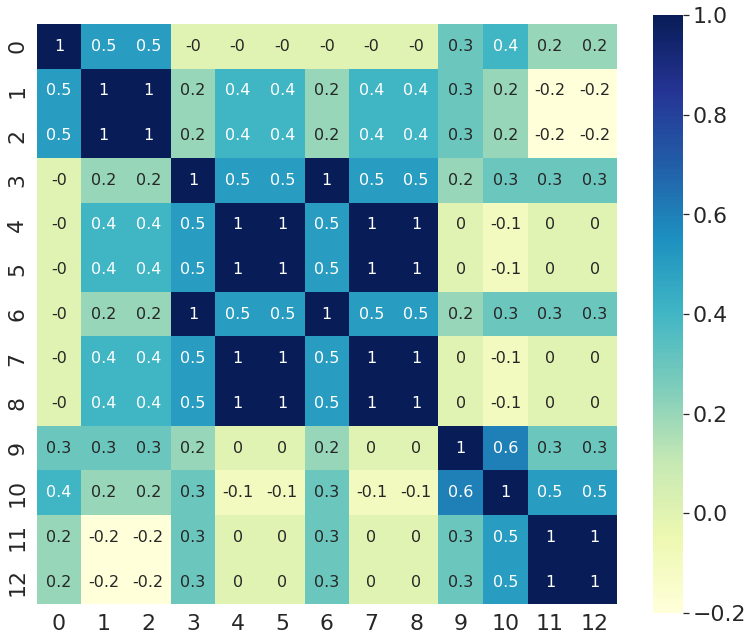

In [38]:
figures[0]

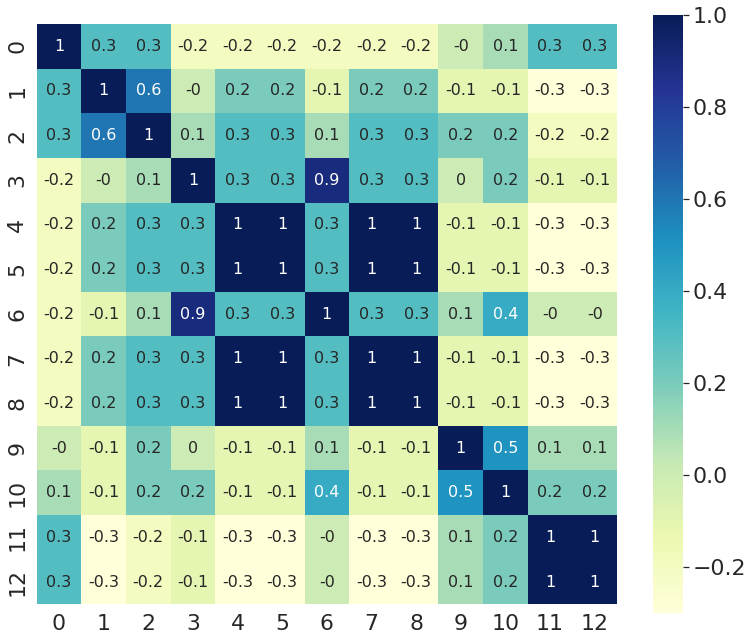

In [39]:
figures[1]

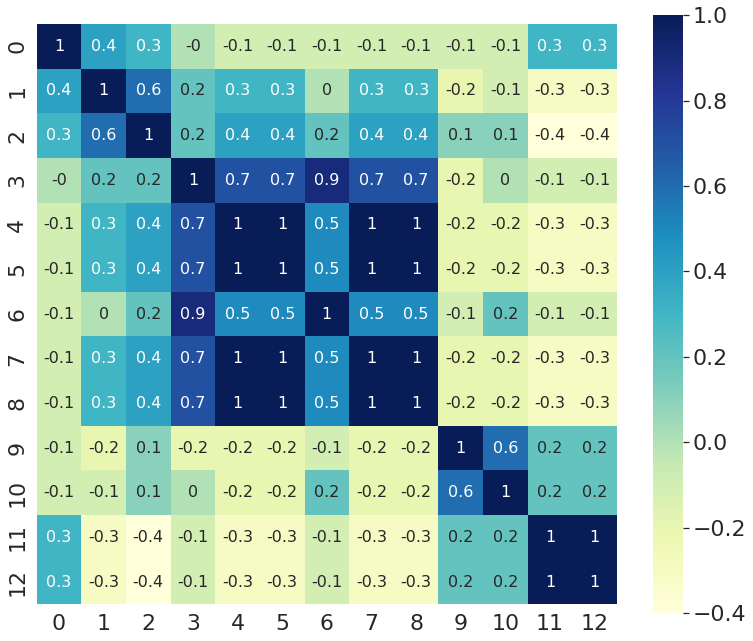

In [40]:
figures[2]

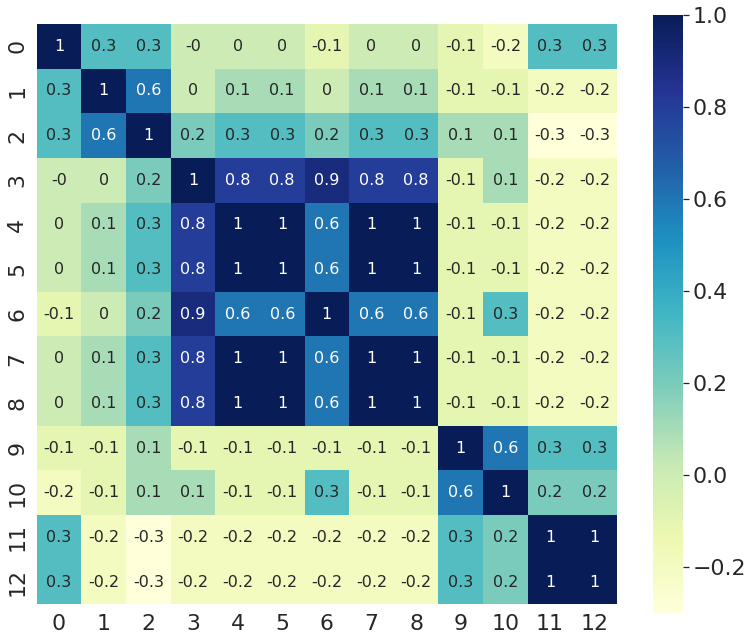

In [41]:
figures[3]